In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [61]:
task2 = np.load('./data_task2.npy')
task2_label = np.load('./label_task2.npy')

In [62]:
print(task2.shape)
print(task2_label.shape)

(180, 10, 10)
(180,)


In [63]:
tensor_x = torch.Tensor(task2)
tensor_y = torch.Tensor(task2_label)

tensor_x = tensor_x.unsqueeze(1)

task2_dataset = TensorDataset(tensor_x,tensor_y)

In [64]:
tensor_x = torch.Tensor(task2)
tensor_y = torch.Tensor(task2_label)

tensor_x = tensor_x.unsqueeze(1)

task2_dataset = TensorDataset(tensor_x,tensor_y)

In [65]:
tensor_x.shape

torch.Size([180, 1, 10, 10])

In [107]:
input_len = len(task2_dataset)
test_ratio = 0.0
test_size = int(input_len * test_ratio)
train_size = input_len - test_size

print(input_len, train_size, test_size)

180 180 0


In [108]:
train_data, test_data = torch.utils.data.random_split(task2_dataset, (train_size, test_size))
print(len(train_data), len(test_data))

180 0


In [109]:
task2_train_dataloader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=2)
# task2_test_dataloader = DataLoader(test_data, batch_size=6, shuffle=True, num_workers=2)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [115]:
import torch.nn as nn
import torch.nn.functional as F

class Conv2d_net(nn.Module):
    def __init__(self):
        super(Conv2d_net, self).__init__() # 10*10
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # 6@10*10 # 한개 채널의 2d 이미지를 3x3 커널로 6개의 채널을 출력
        self.pool = nn.MaxPool2d(2, 2) # 6@5*5
        self.conv2 = nn.Conv2d(6, 10, 2, padding=1) # 16@ 6*6

        self.fc1 = nn.Linear(10 * 6 * 6, 84) 
        self.fc2 = nn.Linear(84, 36)
        self.fc3 = nn.Linear(36, 3)

        self.drop_3 = nn.Dropout(0.3)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2_bn = nn.BatchNorm2d(10)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1_bn(self.conv1(x))))
        x = F.elu(self.conv2_bn(self.conv2(x)))
        x = x.view(-1, 10 * 6 * 6)
        x = self.drop_3(F.elu((self.fc1(x))))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

task2_model = Conv2d_net()

In [116]:
print(task2_model.parameters)

<bound method Module.parameters of Conv2d_net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=360, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=3, bias=True)
  (drop_3): Dropout(p=0.3, inplace=False)
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>


In [117]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(task2_model.parameters(), lr=0.002)

In [118]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task2_model.pt"
best_acc = 10.0
num_epochs = 201

val_corrects_list = []
val_loss_list = []

In [119]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_corrects = 0.0
    running_loss = 0.0
    task2_model.train()  # Set model to training mode
    for i, data in enumerate(task2_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = task2_model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # task2_model.eval()
    # with torch.no_grad():
    #     val_loss = 0.0
    #     val_corrects = 0
    #     for j, val in enumerate(task2_test_dataloader, 0):
    #         val_x, val_label = val
    #         val_x, val_label = val_x.float(), val_label.long()
    #         val_outputs = task2_model(val_x)
    #         _, val_preds = torch.max(val_outputs, 1)
    #         v_loss = criterion(val_outputs, val_label)
    #         val_loss += (v_loss.item() * val_x.size(0))
    #         val_corrects += torch.sum(val_preds == val_label.data).double()
    #     print("Validation) Acc: {:.4f} ".format(val_corrects/test_size))
    #     val_corrects_list.append(val_corrects/test_size)
    #     val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(task2_model.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/200
----------
Train) Loss: 0.9798 Acc: 0.5611
Saving the best model w/ loss 0.9798
Epoch 1/200
----------
Train) Loss: 0.7462 Acc: 0.6778
Saving the best model w/ loss 0.7462
Epoch 2/200
----------
Train) Loss: 0.6415 Acc: 0.7722
Saving the best model w/ loss 0.6415
Epoch 3/200
----------
Train) Loss: 0.6107 Acc: 0.7389
Saving the best model w/ loss 0.6107
Epoch 4/200
----------
Train) Loss: 0.5417 Acc: 0.7778
Saving the best model w/ loss 0.5417
Epoch 5/200
----------
Train) Loss: 0.5591 Acc: 0.7722
Epoch 6/200
----------
Train) Loss: 0.4734 Acc: 0.8000
Saving the best model w/ loss 0.4734
Epoch 7/200
----------
Train) Loss: 0.4393 Acc: 0.8056
Saving the best model w/ loss 0.4393
Epoch 8/200
----------
Train) Loss: 0.3446 Acc: 0.8611
Saving the best model w/ loss 0.3446
Epoch 9/200
----------
Train) Loss: 0.2768 Acc: 0.9000
Saving the best model w/ loss 0.2768
Epoch 10/200
----------
Train) Loss: 0.2669 Acc: 0.8778
Saving the best model w/ loss 0.2669
Epoch 11/200
----------


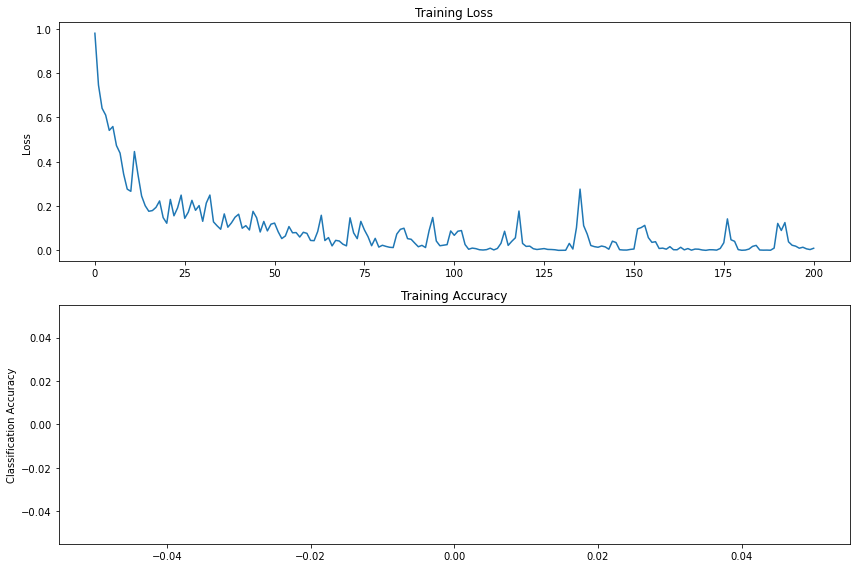

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_corrects_list)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

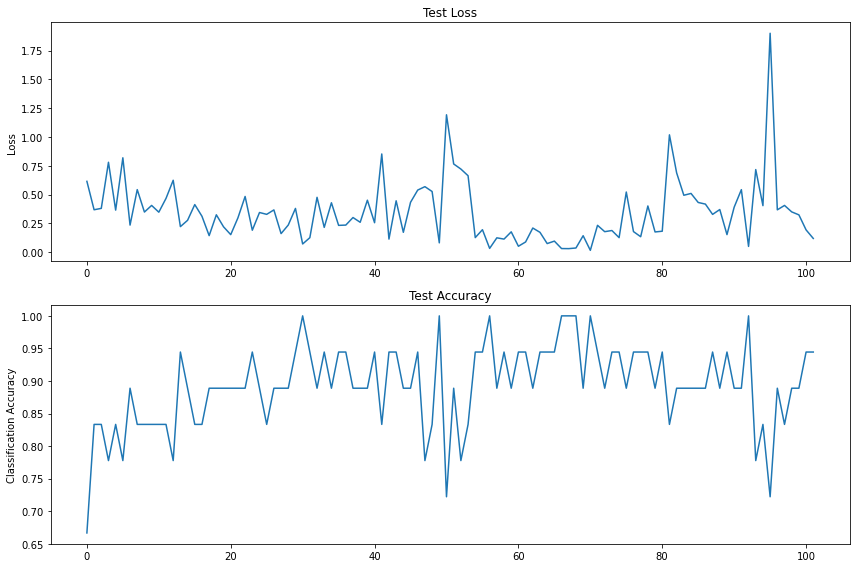

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(val_loss_list)
ax[0].set_ylabel('Loss')
ax[0].set_title('Test Loss')

ax[1].plot(val_corrects_list)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

In [121]:
print("train:",np.array(train_accuracy).mean())
# print("test:",np.array(val_corrects_list).mean())
best_acc

train: 0.9652846876727472


0.0006674339176299781

In [122]:
val_model = Conv2d_net()
val_model.load_state_dict(torch.load(PATH))
val_model.eval()

Conv2d_net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=360, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=3, bias=True)
  (drop_3): Dropout(p=0.3, inplace=False)
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [123]:
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task2_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = val_model(x)
        loss = criterion(outputs, y)
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

Accuracy of the test dataset is: 100 %


ZeroDivisionError: float division by zero

In [59]:
yields = torch.Tensor()
torch.cat(outputs_list, out=yields)
yields = yields.numpy()

In [60]:
targets = torch.Tensor()
torch.cat(y_list, out=targets)
targets = targets.numpy()

In [61]:
print(yields)
print(targets)
print((yields == targets))

[0. 2. 2. 0. 0. 1. 0. 1. 1. 0. 0. 2. 1. 0. 0. 2. 2. 1.]
[0. 2. 2. 0. 0. 1. 0. 2. 1. 0. 0. 2. 1. 0. 0. 2. 2. 1.]
[ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True]


In [63]:
# from tempfile import TemporaryFile
# answer = TemporaryFile()
np.save('label_pred_task2.npy', yields)

In [65]:
answer = np.load('./label_pred_task2.npy')

In [66]:
answer

array([0., 2., 2., 0., 0., 1., 0., 1., 1., 0., 0., 2., 1., 0., 0., 2., 2.,
       1.], dtype=float32)

---

In [39]:
data_test_task2 = np.load('./data_test_task2.npy')

tensor_x = torch.Tensor(data_test_task2)

tensor_x = tensor_x.unsqueeze(1)

task2_dataset = TensorDataset(tensor_x)
task2_dataloader = DataLoader(tensor_x, batch_size=6, shuffle=False, num_workers=2)


In [48]:
data_test_task2 = np.load('./label_pred_task2.npy')
data_test_task2

array([0., 2., 2., 0., 0., 1., 0., 1., 1., 0., 0., 2., 1., 0., 0., 2., 2.,
       1.], dtype=float32)

In [53]:
outputs_list = []
total = 0
with torch.no_grad():
    # for data in task2_dataloader:
    tensor_x=tensor_x.float()
    tensor_x.shape
    outputs = val_model(tensor_x)
    _, predicted = torch.max(outputs.data, 1)
    outputs_list.append(predicted[:])
    total += tensor_x.size(0)

In [58]:
total

120

In [59]:
outputs_list

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [56]:
yields = torch.Tensor()
torch.cat(outputs_list, out=yields)
yields = yields.numpy()

In [57]:
yields

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)